Importing Necessary Libraries...

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
# cloning the github repository containing the dataset
!git clone https://github.com/Yuvnish017/Dynamic_Hand_Gesture_Recognition.git

Cloning into 'Dynamic_Hand_Gesture_Recognition'...
remote: Enumerating objects: 14880, done.
remote: Counting objects: 100% (14880/14880), done.
remote: Compressing objects: 100% (14621/14621), done.
remote: Total 14880 (delta 264), reused 14867 (delta 255), pack-reused 0
Receiving objects: 100% (14880/14880), 32.48 MiB | 23.98 MiB/s, done.
Resolving deltas: 100% (264/264), done.


#### Loading the Dataset

In [3]:
# lists for storing images and labels
X = []
Y = []

# dictionary for maping class labels to integer labels
d = {'ClosingFist': 0,
     'LeftSwipe': 1,
     'OpeningFist': 2,
     'RightSwipe': 3,
     'SwipeDown': 4,
     'SwipeUp': 5,
     'ThumbsDown': 6,
     'ThumbsUp': 7}

datadir = 'Dynamic_Hand_Gesture_Recognition/dataset'
for classes in os.listdir(datadir):
  path = os.path.join(datadir, classes)
  for folder in os.listdir(path):
    m = np.zeros(shape=(30, 128, 128, 1))
    imgs = os.path.join(path, folder)
    for i, img in enumerate(os.listdir(imgs)):
      image = cv2.imread(os.path.join(imgs, img))

      # converting to gray scale image
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = np.array(image)

      # making the shape of image (128, 128, 1)
      image = np.expand_dims(image, axis=-1)

      # normalizing the pixel intensities
      image = image/255.
      m[int(int(os.path.splitext(img)[0])/5), :, :, :] = image
    X.append(m)
    Y.append(d[classes])

print(len(X))
print(len(Y))

480
480


In [4]:
# duplicating the data for increasing the size of dataset
X = X*2
Y = Y*2

#### Visulaizing data samples form each class

ClosingFist


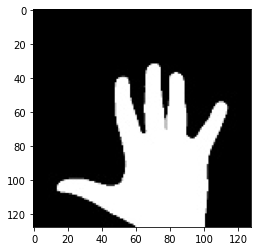

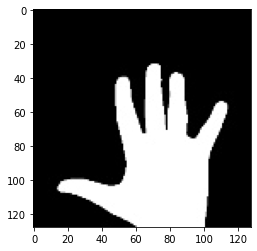

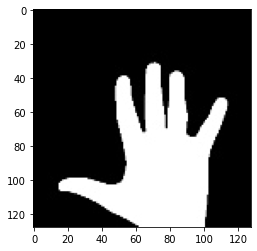

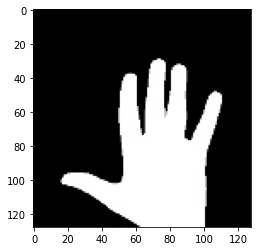

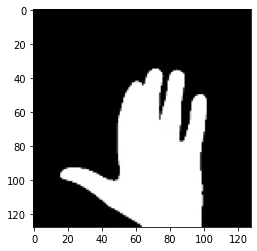

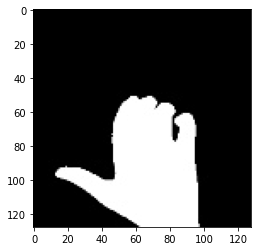

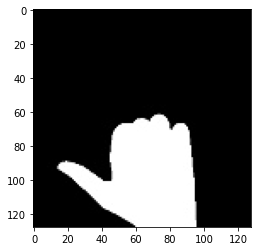

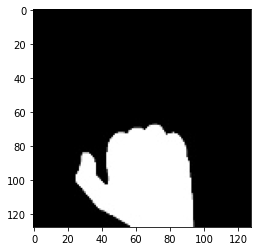

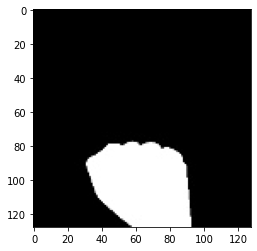

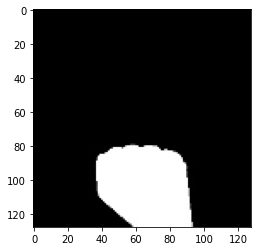

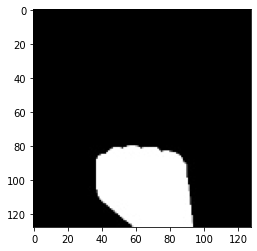

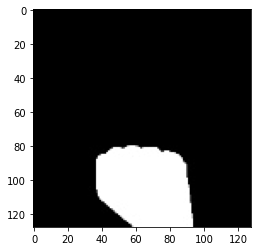

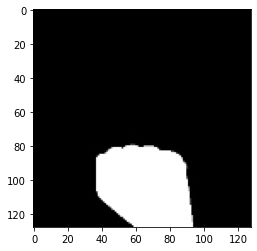

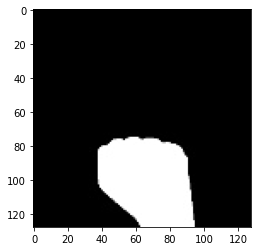

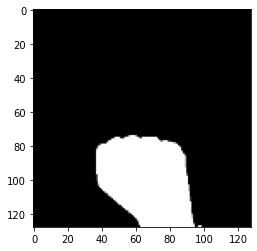

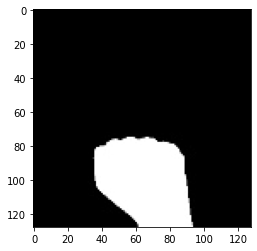

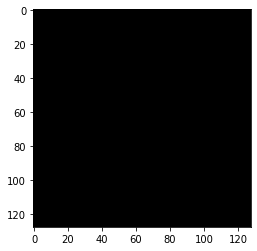

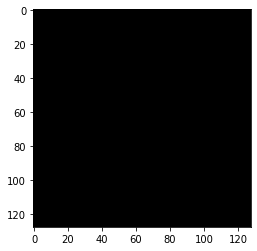

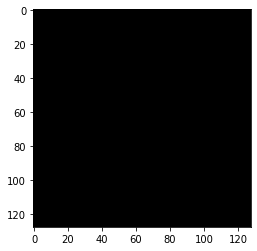

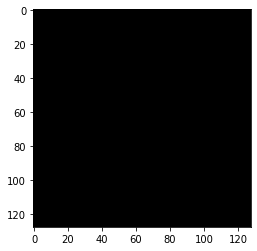

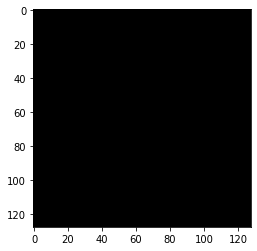

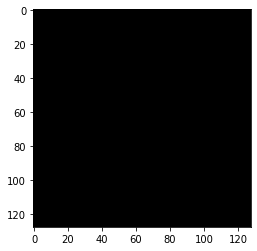

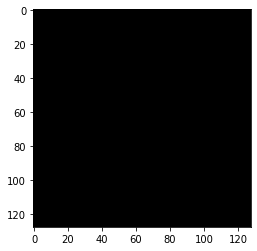

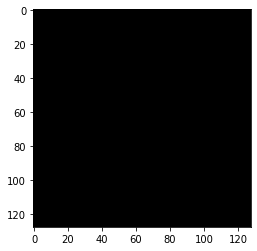

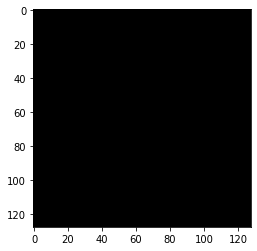

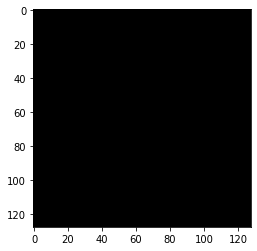

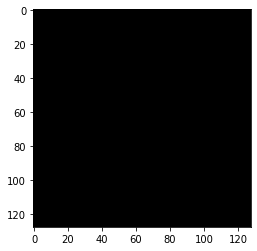

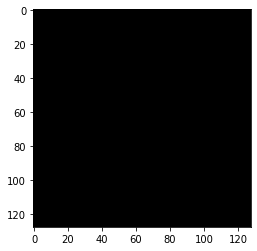

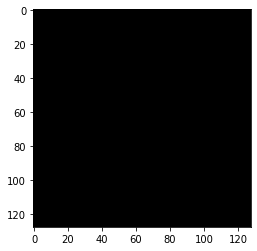

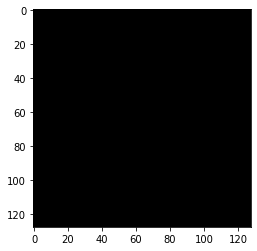

LeftSwipe


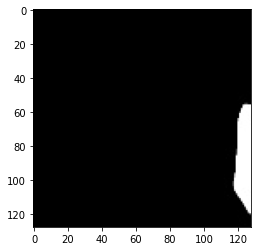

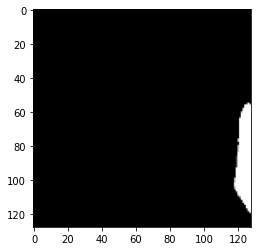

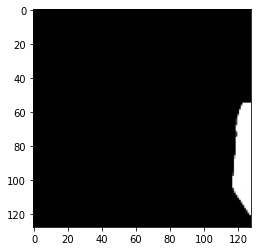

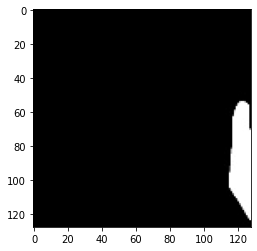

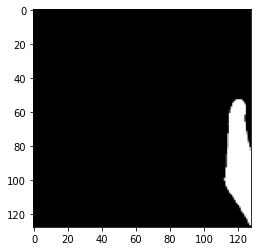

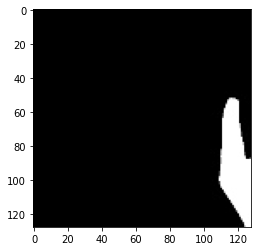

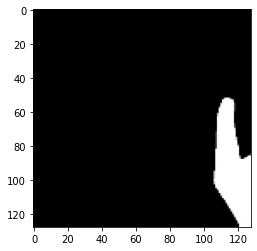

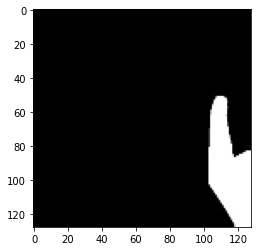

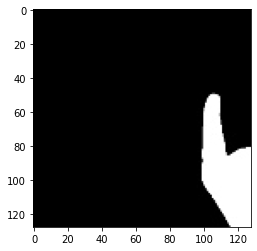

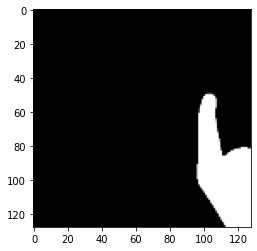

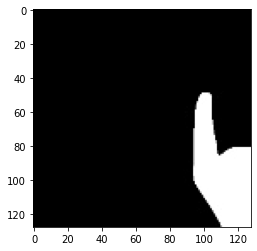

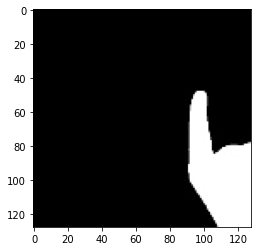

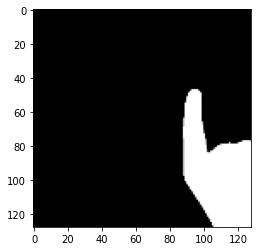

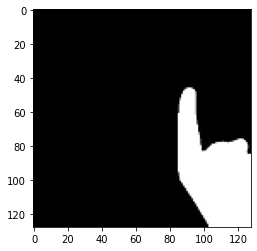

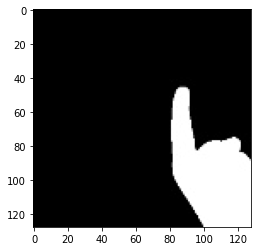

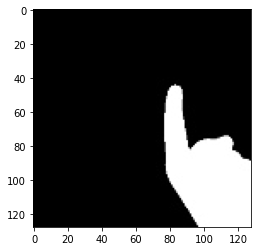

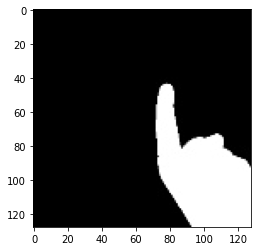

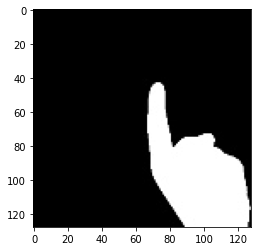

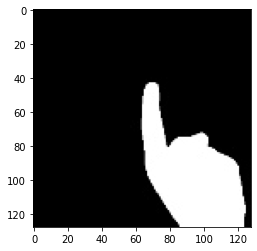

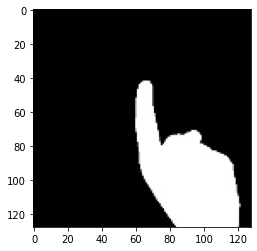

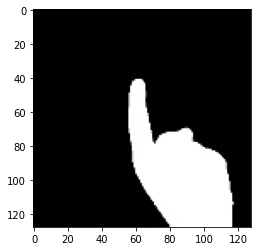

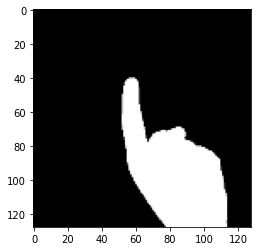

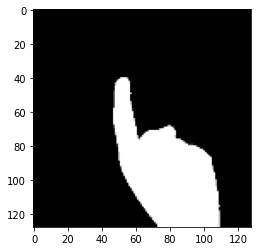

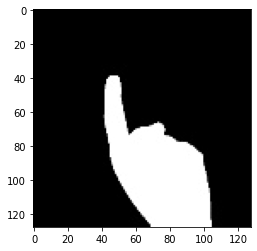

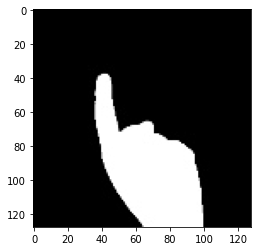

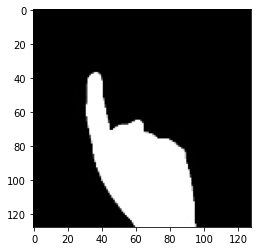

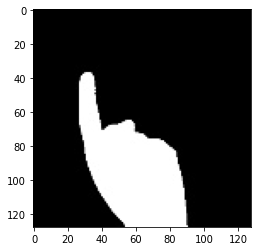

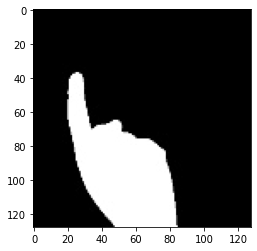

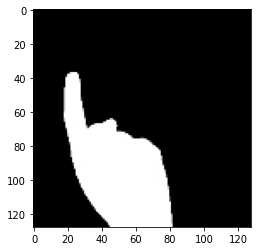

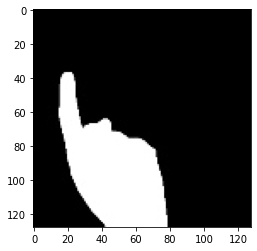

OpeningFist


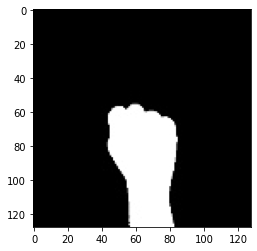

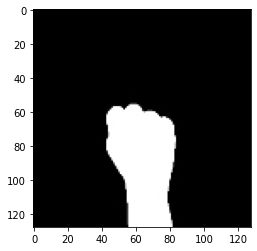

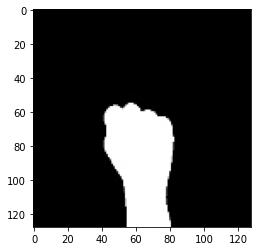

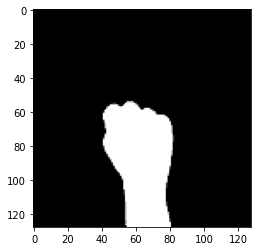

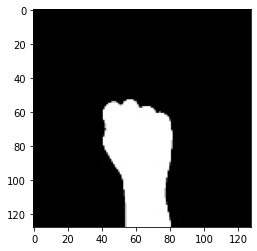

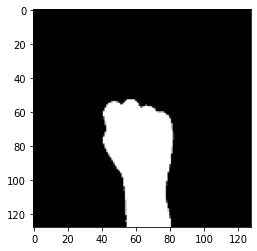

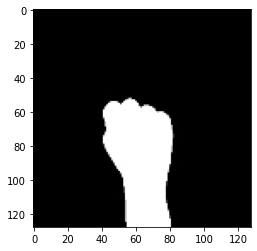

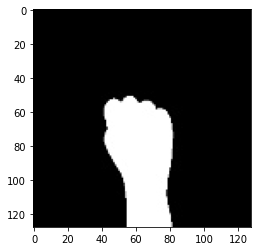

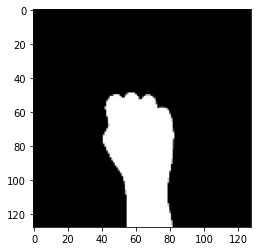

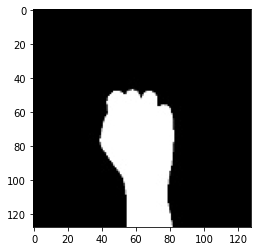

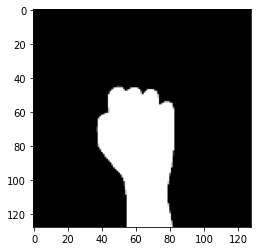

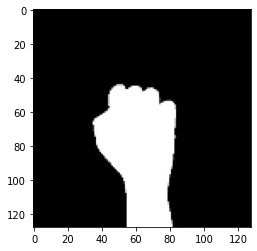

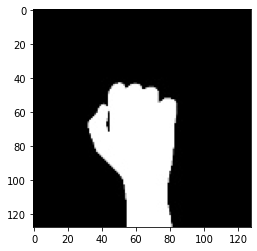

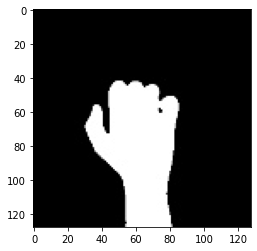

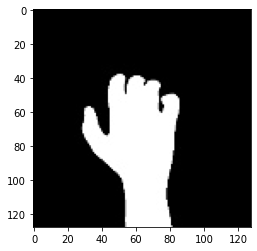

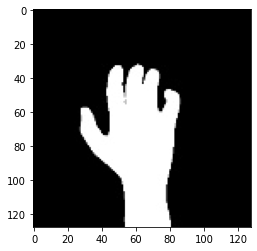

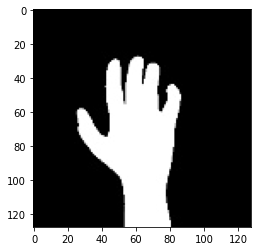

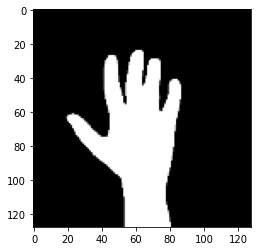

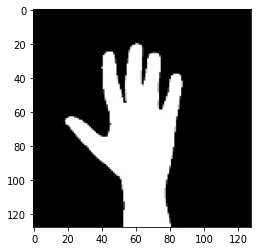

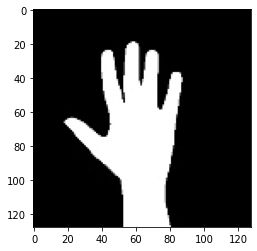

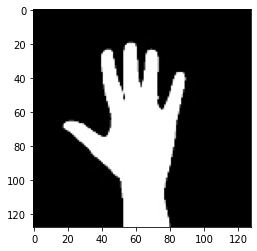

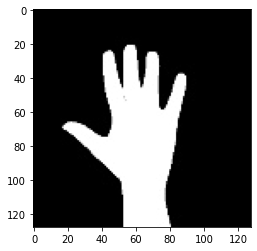

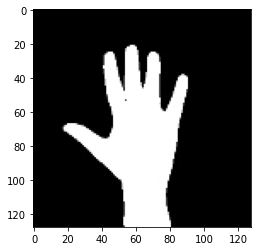

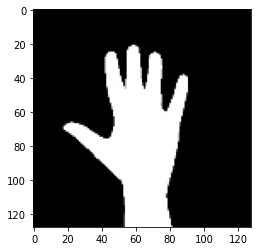

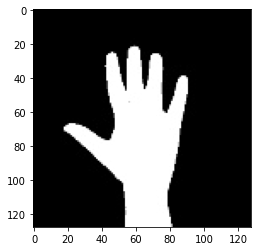

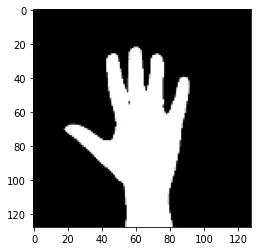

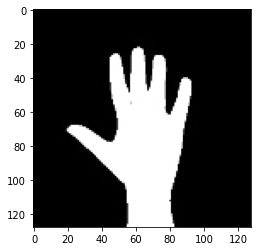

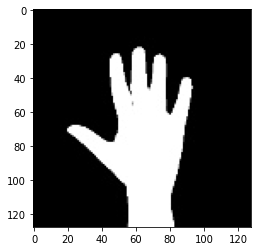

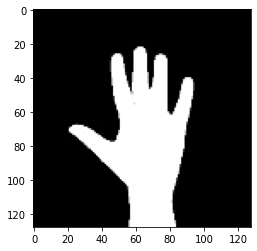

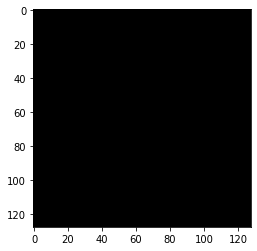

RightSwipe


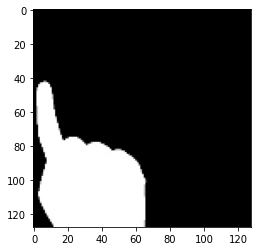

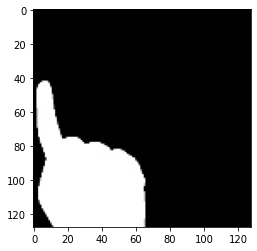

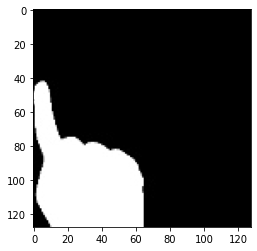

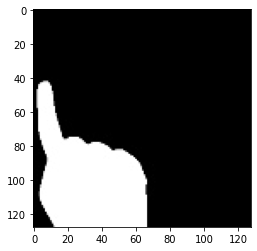

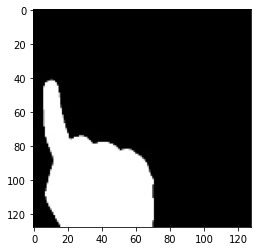

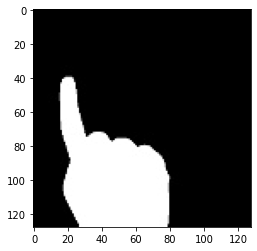

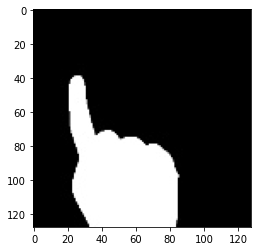

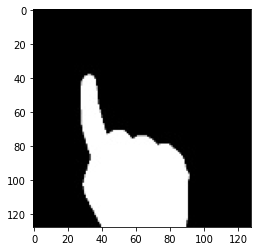

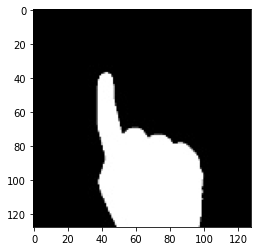

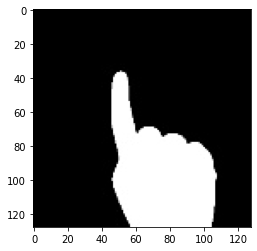

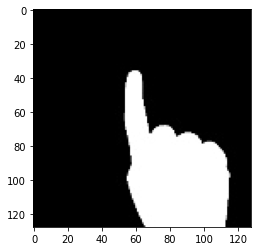

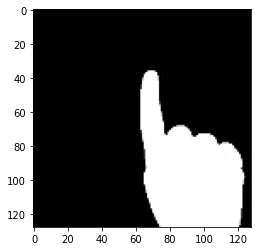

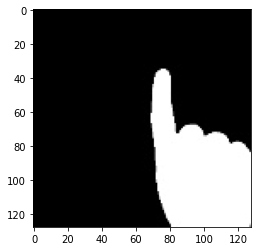

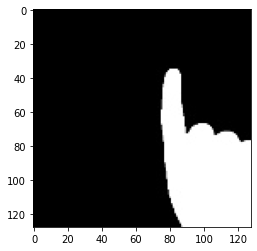

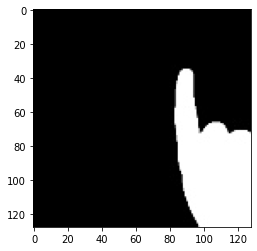

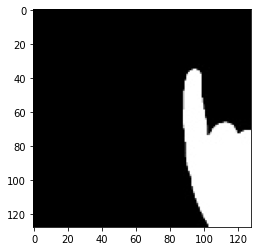

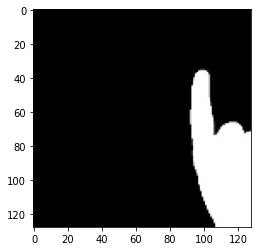

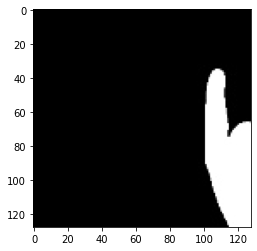

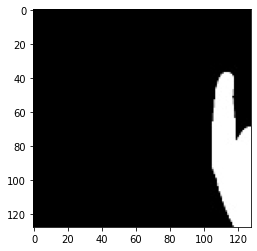

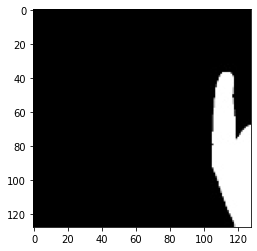

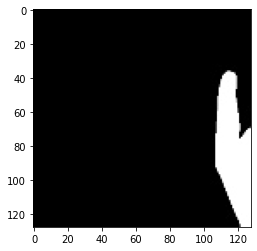

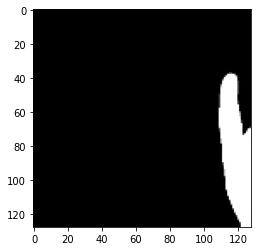

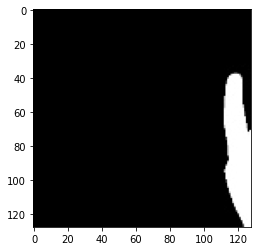

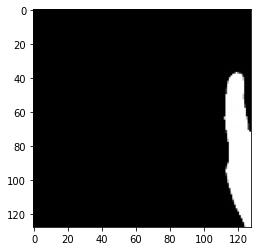

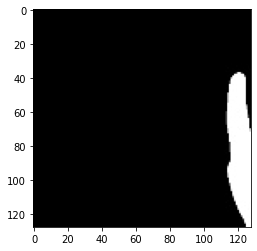

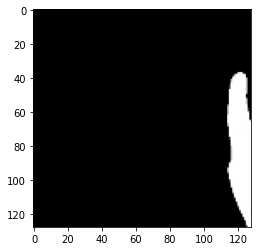

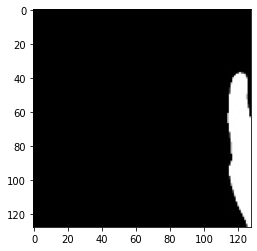

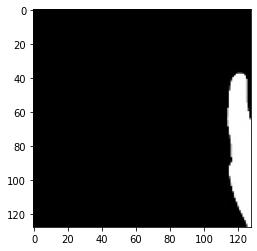

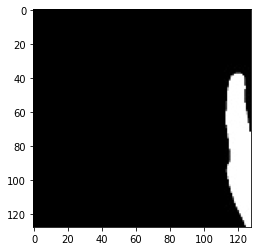

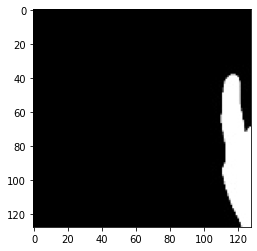

SwipeDown


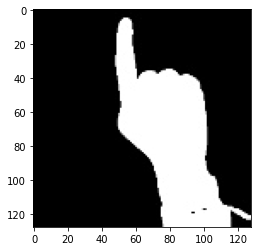

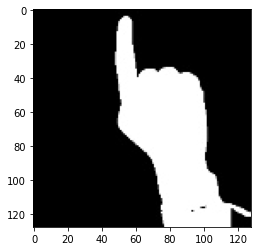

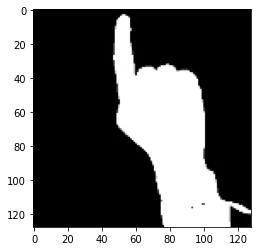

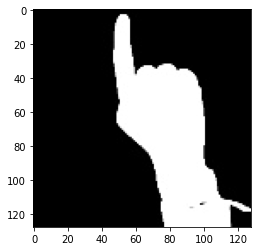

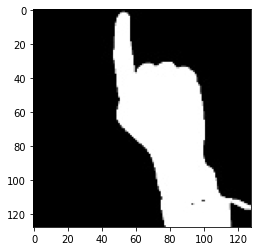

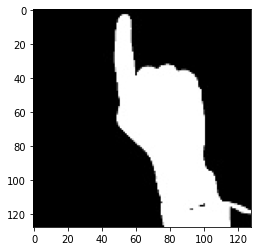

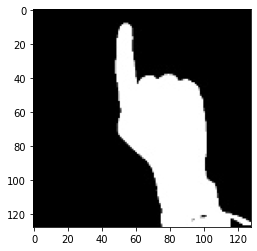

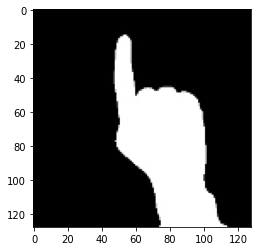

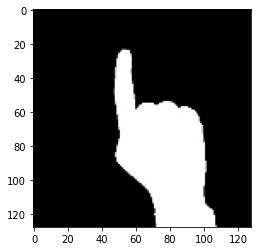

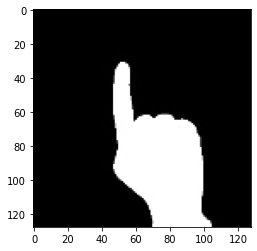

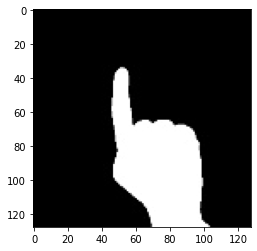

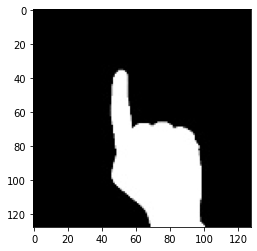

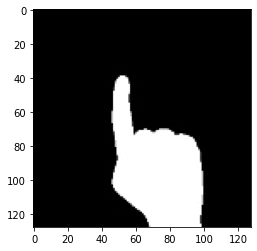

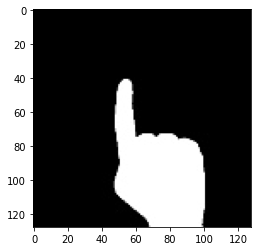

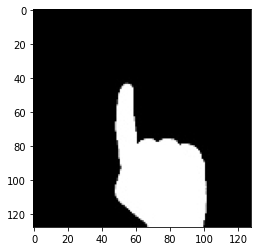

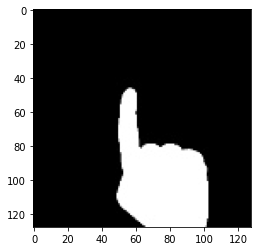

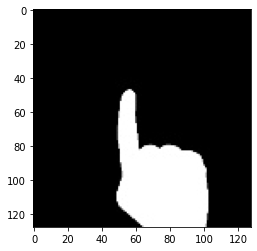

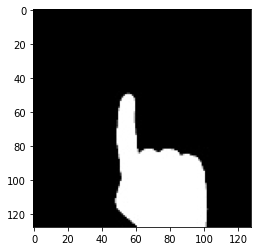

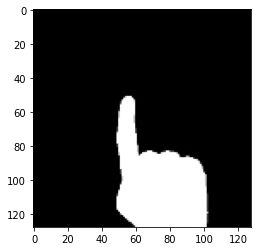

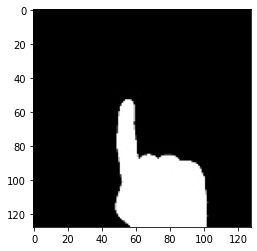

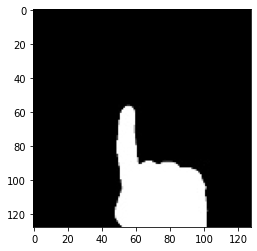

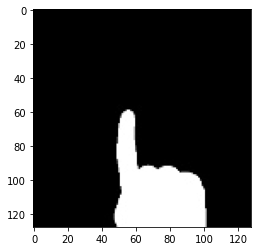

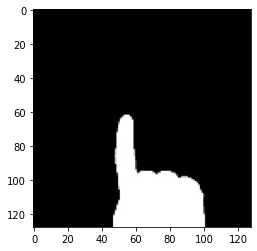

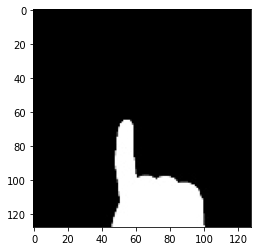

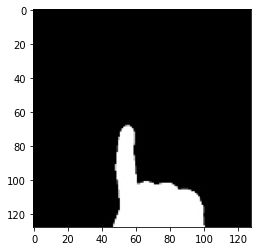

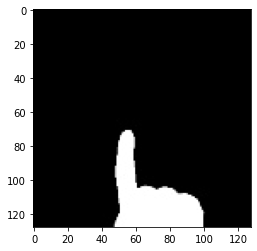

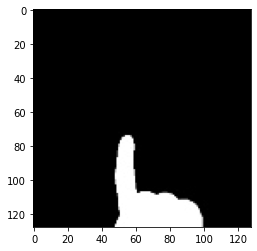

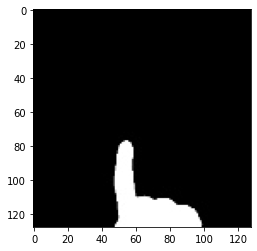

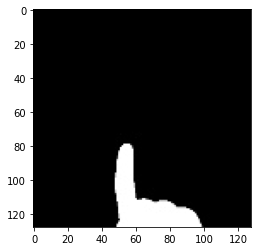

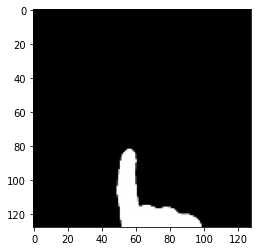

SwipeUp


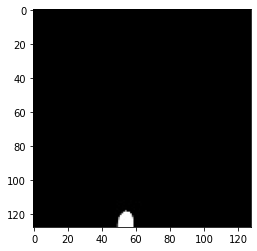

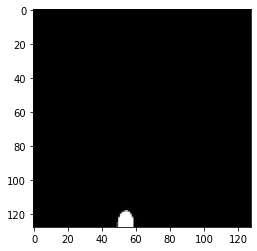

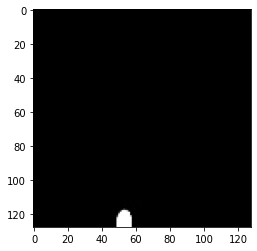

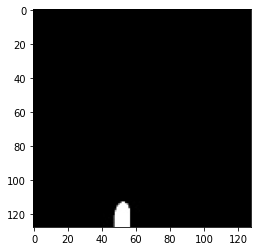

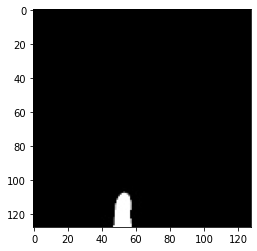

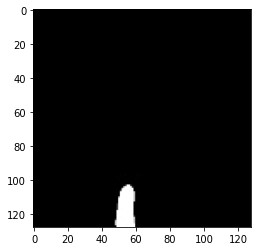

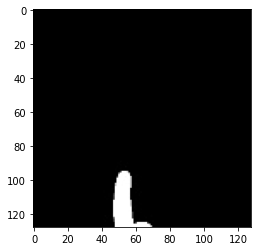

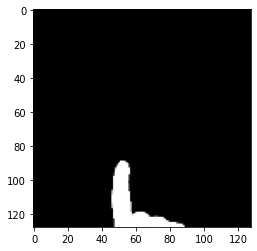

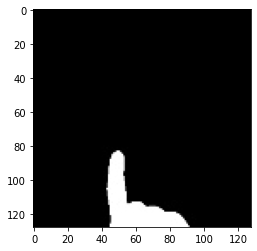

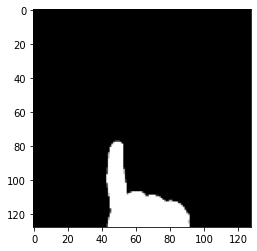

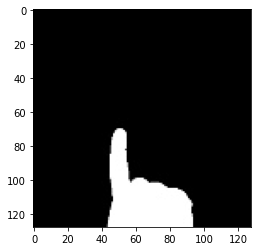

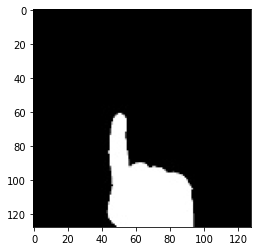

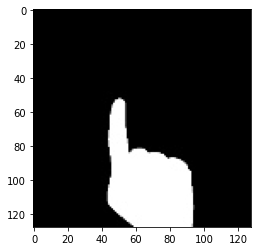

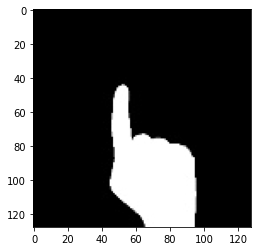

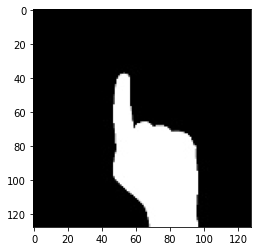

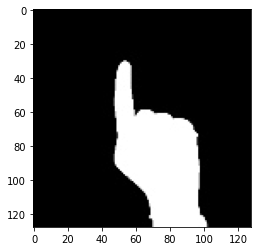

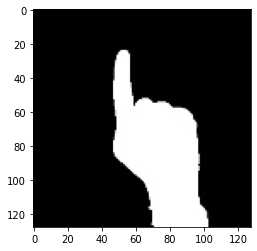

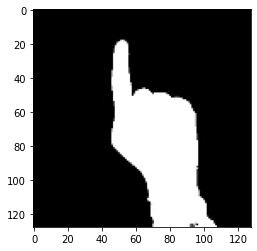

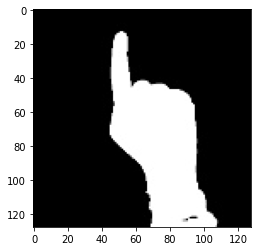

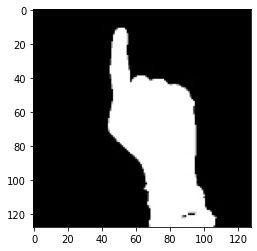

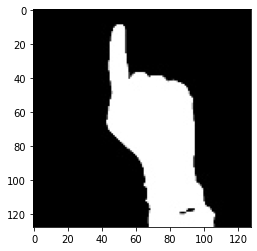

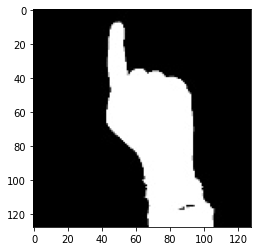

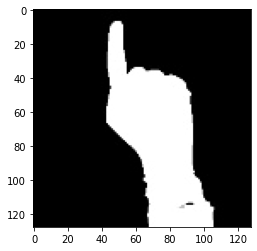

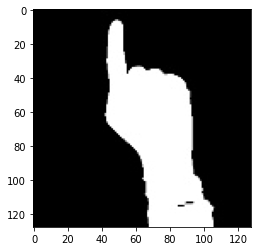

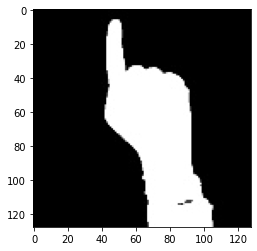

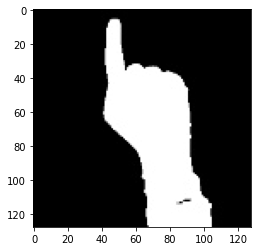

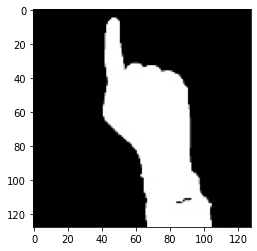

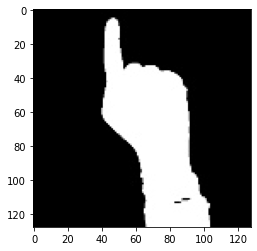

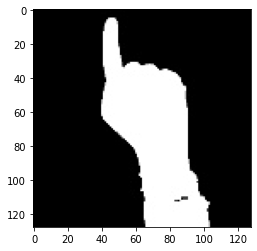

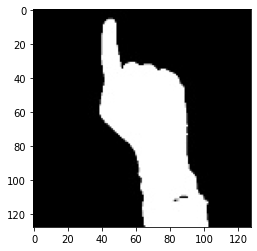

ThumbsDown


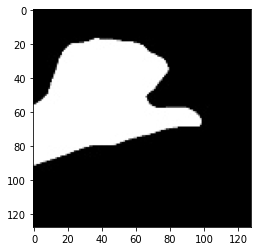

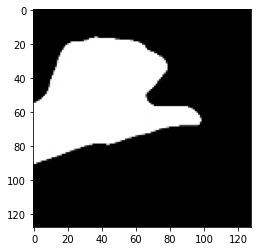

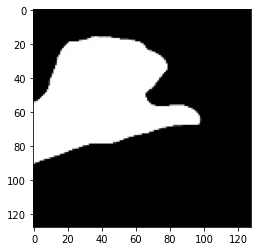

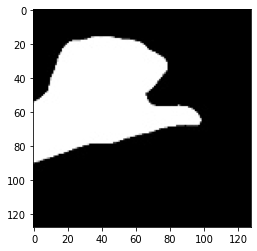

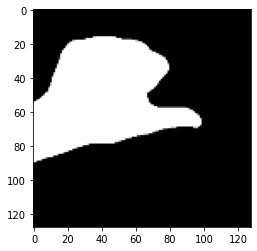

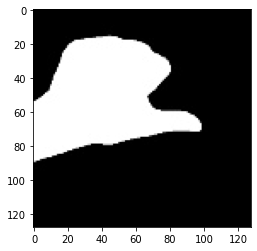

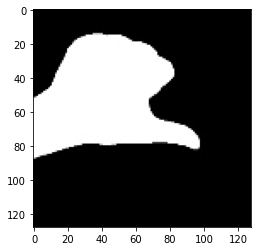

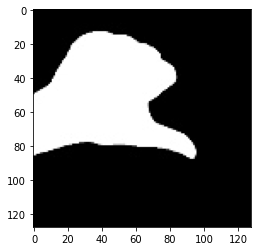

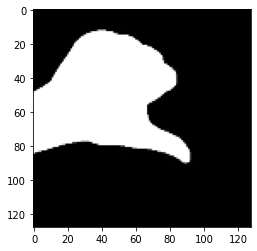

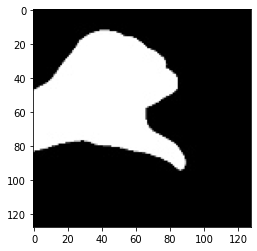

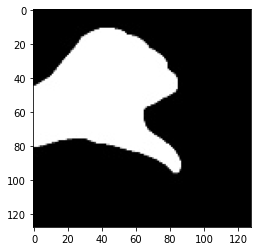

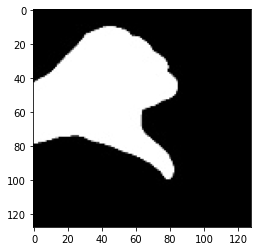

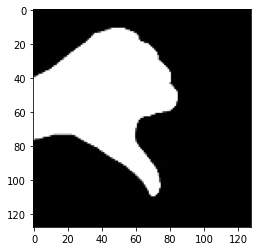

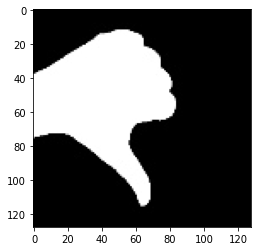

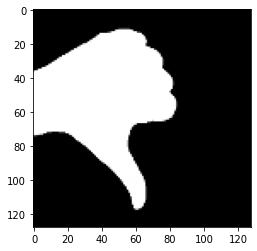

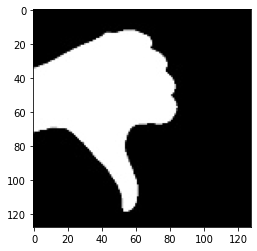

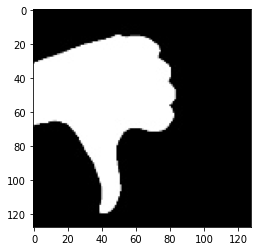

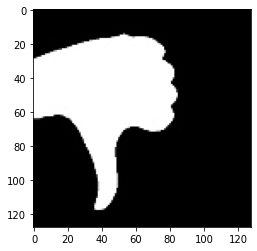

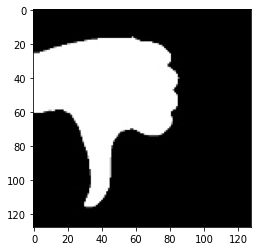

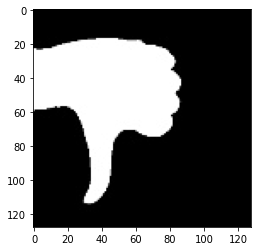

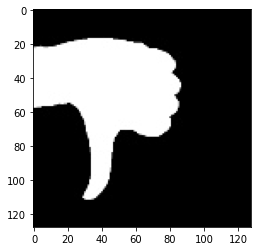

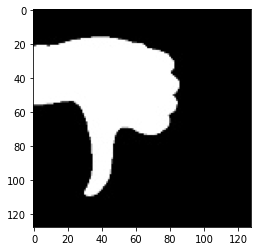

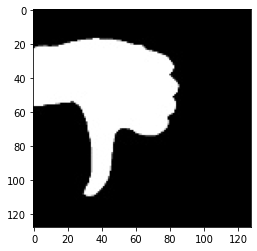

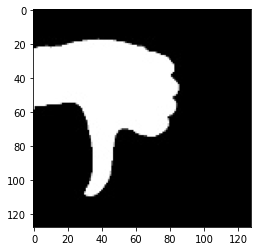

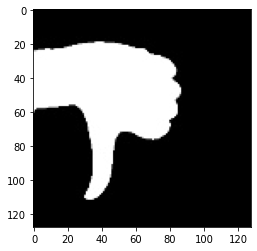

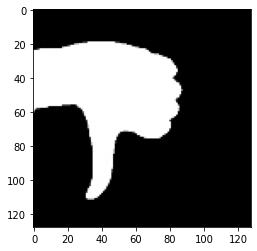

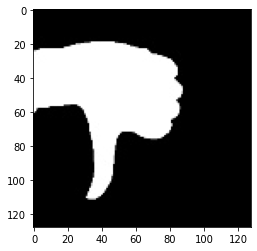

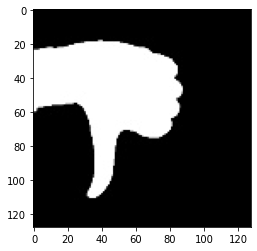

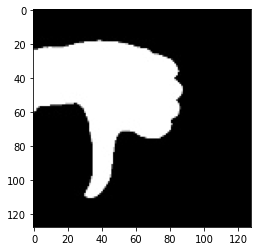

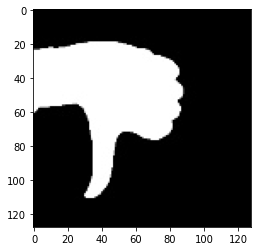

ThumbsUp


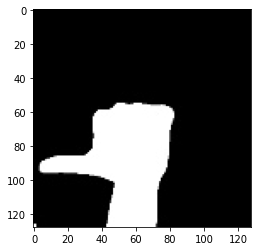

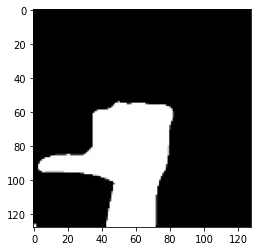

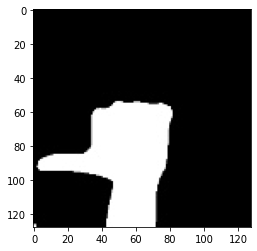

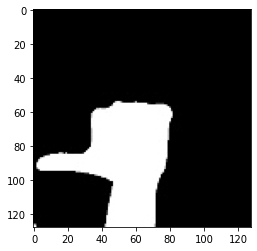

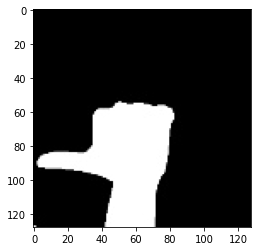

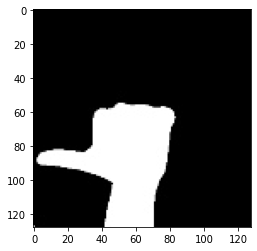

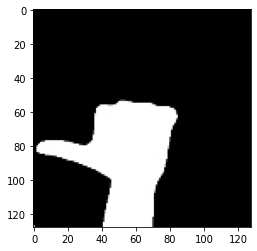

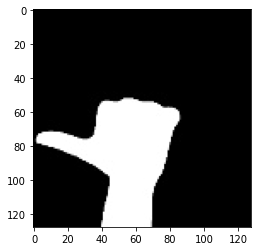

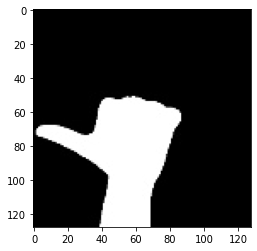

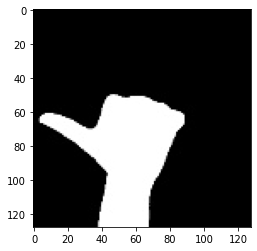

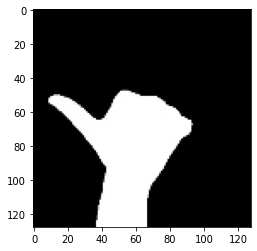

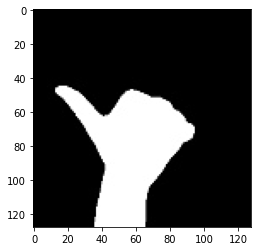

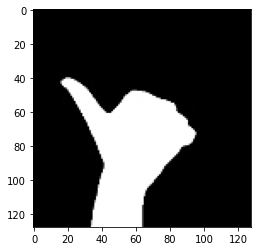

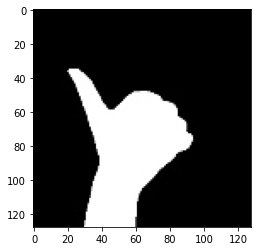

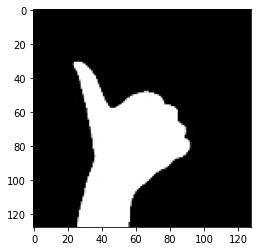

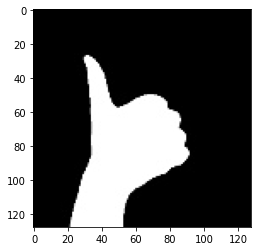

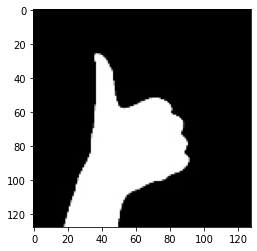

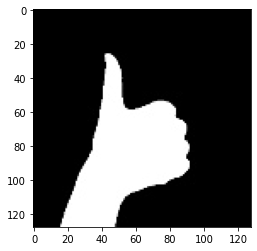

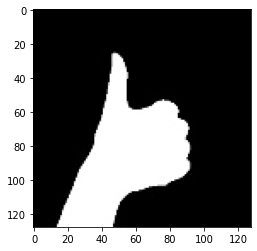

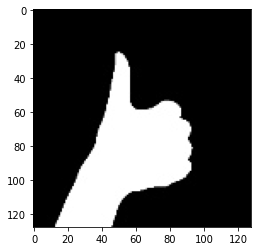

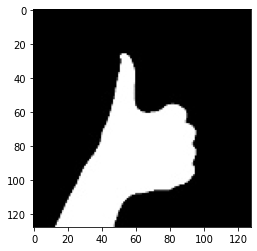

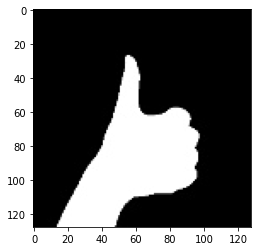

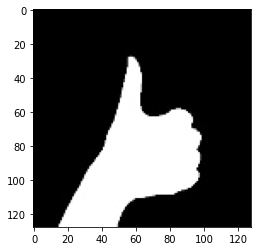

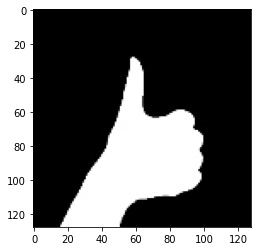

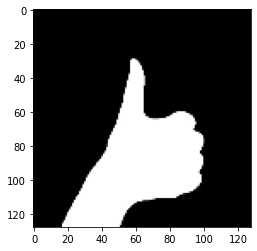

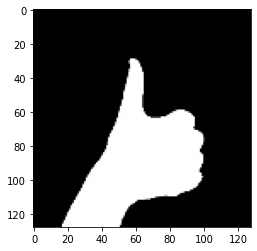

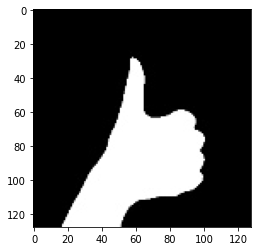

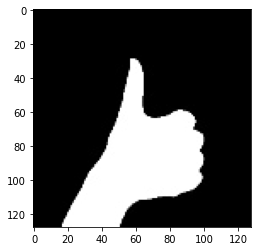

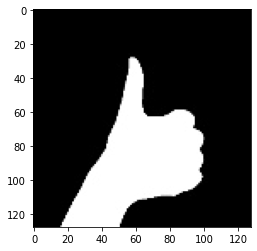

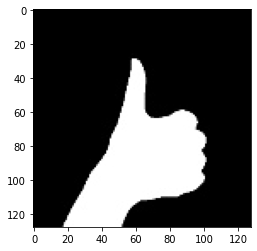

In [5]:
for j in d:
  idx = Y.index(d[j])
  print(j)
  for i in range(30):
    plt.imshow(np.squeeze(X[idx][i], axis=-1), cmap='gray')
    plt.show()

#### Visualizing number of data samples per category

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


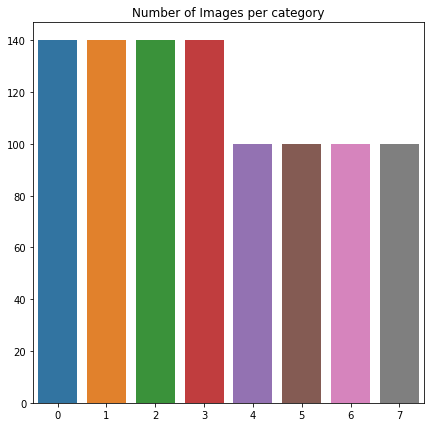

In [6]:
unique, count = np.unique(Y, return_counts=True)
figure = plt.figure(figsize=(7, 7))
sns.barplot(unique, count).set_title('Number of Images per category')
plt.savefig('number_of_images_per_category.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Converting to numpy arrays and labels to one-hot encodings
X = np.array(X)
Y = np.array(Y)

Y = to_categorical(Y)

print(X.shape)
print(Y.shape)

(960, 30, 128, 128, 1)
(960, 8)


In [8]:
# Splitting dataset into train and test set
np.random.seed(0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(768, 30, 128, 128, 1)
(768, 8)
(192, 30, 128, 128, 1)
(192, 8)


#### Applying transformation in data to introduce variation in dataset

In [9]:
def translation(img, translation_amount=10):
  # for translation 
  rows, cols = img.shape
  M = np.float32([[1, 0, translation_amount],
                [0, 1, translation_amount],
                [0, 0, 1]])
  translated_img = cv2.warpPerspective(img, M, (cols, rows))
  translated_img = cv2.resize(translated_img, (128, 128))
  return translated_img


def scaling(img, scaling_factor=1.1):
  # for scaling the image
  rows, cols = img.shape
  M = np.float32([[scaling_factor, 0  , 0],
                [0,   scaling_factor, 0],
                [0,   0,   1]])
  scaled_img = cv2.warpPerspective(img,M,(cols*2,rows*2))
  scaled_img = cv2.resize(scaled_img, (128, 128))
  return scaled_img


def x_shearing(img, shearing_factor=0.1):
  # for shearing in x direction
  rows, cols = img.shape

  M = np.float32([[1, shearing_factor, 0],
                [0, 1  , 0],
                [0, 0  , 1]])
  
  # apply a perspective transformation to the image                
  sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
  sheared_img = cv2.resize(sheared_img, (128, 128))
  return sheared_img


def y_shearing(img, shearing_factor=0.1):
  # for shearing in y-direction
  rows, cols = img.shape
  M = np.float32([[1,   0, 0],
              	  [shearing_factor, 1, 0],
              	  [0,   0, 1]])
  sheared_img = cv2.warpPerspective(img,M,(int(cols*1.5),int(rows*1.5)))
  sheared_img = cv2.resize(sheared_img, (128, 128))
  return sheared_img


def rotation(img, angle=10):
  # for rotation of image by certain angle
  rows, cols = img.shape
  angle = np.radians(angle)
  M = np.float32([[np.cos(angle), -(np.sin(angle)), 0],
                [np.sin(angle), np.cos(angle), 0],
                [0, 0, 1]])
  rotated_img = cv2.warpPerspective(img, M, (int(cols),int(rows)))
  rotated_img = cv2.resize(rotated_img, (128, 128))
  return rotated_img

In [10]:
# Applying transformations to images in training set
for i in range(X_train.shape[0]):
  if i%5 == 0:
    for j in range(30):
      X_train[i, j, :, :, :] = np.expand_dims(translation(np.squeeze(X_train[i, j, :, :, :], axis=-1)), axis=-1)

  elif i%5 == 1:
    for j in range(30):
      X_train[i, j, :, :, :] = np.expand_dims(scaling(np.squeeze(X_train[i, j, :, :, :], axis=-1)), axis=-1)

  elif i%5 == 2:
    for j in range(30):
      X_train[i, j, :, :, :] = np.expand_dims(x_shearing(np.squeeze(X_train[i, j, :, :, :], axis=-1)), axis=-1)

  elif i%5 == 3:
    for j in range(30):
      X_train[i, j, :, :, :] = np.expand_dims(y_shearing(np.squeeze(X_train[i, j, :, :, :], axis=-1)), axis=-1)

  elif i%5 == 4:
    for j in range(30):
      X_train[i, j, :, :, :] = np.expand_dims(rotation(np.squeeze(X_train[i, j, :, :, :], axis=-1)), axis=-1) 

In [11]:
# Applying transformation to images in test set
for i in range(X_test.shape[0]):
  if i%5 == 0:
    for j in range(30):
      X_test[i, j, :, :, :] = np.expand_dims(translation(np.squeeze(X_test[i, j, :, :, :], axis=-1), translation_amount=15), axis=-1)

  elif i%5 == 1:
    for j in range(30):
      X_test[i, j, :, :, :] = np.expand_dims(scaling(np.squeeze(X_test[i, j, :, :, :], axis=-1), scaling_factor=1.2), axis=-1)

  elif i%5 == 2:
    for j in range(30):
      X_test[i, j, :, :, :] = np.expand_dims(x_shearing(np.squeeze(X_test[i, j, :, :, :], axis=-1), shearing_factor=0.15), axis=-1)

  elif i%5 == 3:
    for j in range(30):
      X_test[i, j, :, :, :] = np.expand_dims(y_shearing(np.squeeze(X_test[i, j, :, :, :], axis=-1), shearing_factor=0.15), axis=-1)

  elif i%5 == 4:
    for j in range(30):
      X_test[i, j, :, :, :] = np.expand_dims(rotation(np.squeeze(X_test[i, j, :, :, :], axis=-1), angle=25), axis=-1) 

#### Model Building and Training

In [12]:
# Defining the model
model = Sequential()
model.add(Input(shape=(30, 128, 128, 1)))
model.add(Conv3D(16, (5, 5, 5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=100), name='conv1'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=100), name='conv2'))
model.add(MaxPool3D((1, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=100), name='conv3'))
model.add(MaxPool3D((1, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=100), name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=100), name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax', kernel_initializer=glorot_uniform(seed=100), name='fc3'))

opt = Adam(learning_rate=2e-4)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 30, 128, 128, 16)  2016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 64, 64, 16)   64        
 ormalization)                                                   
                                                                 
 conv2 (Conv3D)              (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 32, 32, 32)   0         
 3D)                                                             
                                                        

In [13]:
# defining model checkpoints and callbacks for saving the model and reducing learning rate 
checkpoint = ModelCheckpoint('hand_gesture_recognition.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, )

def step_decay(epoch):
    # for step decay in learning rate
    # can be used with LearningRateScheduler
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

callbacks = [checkpoint, LR]

# uncomment the below line for using step decay as Learning Rate Scheduler
# callbacks = [checkpoint, LearningRateScheduler(step_decay)]

# training the model
hist = model.fit(X_train, Y_train, batch_size=32, epochs=35, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/35
24/24 [==============================] - ETA: 0s - loss: 1.0714 - accuracy: 0.6536
Epoch 00001: val_loss improved from inf to 2.14869, saving model to hand_gesture_recognition.h5
24/24 [==============================] - 60s 2s/step - loss: 1.0714 - accuracy: 0.6536 - val_loss: 2.1487 - val_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/35
24/24 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.9036
Epoch 00002: val_loss did not improve from 2.14869
24/24 [==============================] - 43s 2s/step - loss: 0.3919 - accuracy: 0.9036 - val_loss: 2.3782 - val_accuracy: 0.1771 - lr: 2.0000e-04
Epoch 3/35
24/24 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9688
Epoch 00003: val_loss did not improve from 2.14869
24/24 [==============================] - 43s 2s/step - loss: 0.1890 - accuracy: 0.9688 - val_loss: 2.4567 - val_accuracy: 0.1771 - lr: 2.0000e-04
Epoch 4/35
24/24 [==============================] - ETA: 0s - loss: 0.1420 - accur

#### Accuracy and Loss vs Epochs plot for Training and Test Set

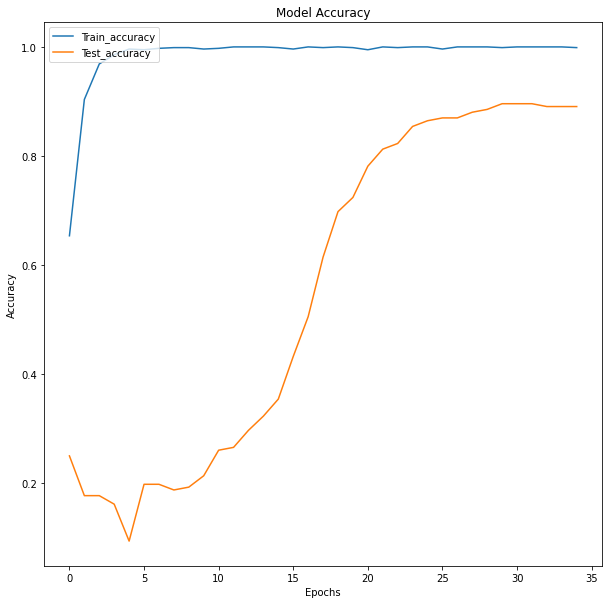

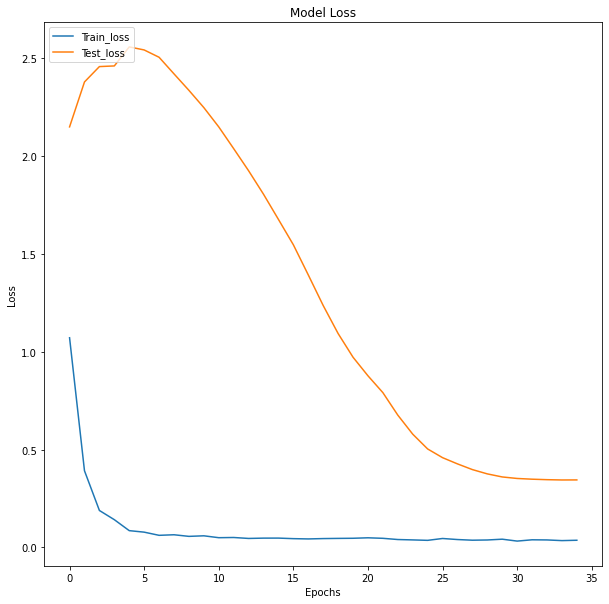

In [14]:
figure1 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.savefig('accuracy_vs_epoch_plot.png', dpi=300, bbox_inches='tight')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.savefig('loss_vs_epoch_plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### Classification Report for Test Set

In [15]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
Y_test_copy = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_copy, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.89      1.00      0.94        34
           2       1.00      0.80      0.89        30
           3       0.83      0.96      0.89        25
           4       0.88      0.70      0.78        20
           5       0.80      1.00      0.89        16
           6       1.00      0.93      0.97        15
           7       1.00      0.97      0.98        29

    accuracy                           0.89       192
   macro avg       0.89      0.89      0.88       192
weighted avg       0.90      0.89      0.89       192



#### Confusion Matrix for Test Set

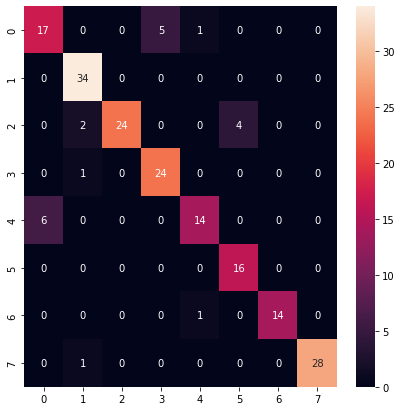

In [16]:
matrix = confusion_matrix(Y_test_copy, y_pred_test)
figure = plt.figure(figsize=(7, 7))
df = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7], columns=[0, 1, 2, 3, 4, 5, 6, 7])
sns.heatmap(df, annot=True, fmt='d')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()